In [1]:
%load_ext zipline
import zipline

In [6]:
from zipline.api import order_target_percent, record, symbol, set_benchmark, get_open_orders
from datetime import datetime
import pytz
import warnings
warnings.filterwarnings('ignore')

In [7]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')
    set_benchmark(symbol('AAPL'))
    
def handle_data(context, data):
    # Skip first 200 days to get full windows
    context.i += 1
    if context.i < 200:
            return
    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=50, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=200, frequency="1d").mean()

    # Trading logic
    open_orders = get_open_orders()

    if context.asset not in open_orders:
        if short_mavg > long_mavg:
            # order_target orders as many shares as needed to
            # achieve the desired number of shares.
            order_target_percent(context.asset, 1.0)
        elif short_mavg < long_mavg:
            order_target_percent(context.asset, 0.0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
            short_mavg=short_mavg,
            long_mavg=long_mavg)

In [8]:
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 12, 31, 0, 0, 0, 0, pytz.utc)

perf = zipline.run_algorithm(start=start,
                end=end,
                initialize=initialize,
                capital_base=10000,
                handle_data=handle_data)

Start date,2000-01-03
End date,2017-12-29
Total months,215
,Backtest
Annual return,23.8%
Cumulative returns,4520.0%
Annual volatility,27.9%
Sharpe ratio,0.91
Calmar ratio,0.41
Stability,0.93
Max drawdown,-57.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,57.76,2007-12-28,2008-09-23,2010-09-22,714
1,53.57,2001-07-17,2003-06-09,2004-09-08,822
2,34.42,2006-01-13,2006-10-11,2007-05-21,352
3,25.90,2012-09-19,2013-09-16,2014-05-23,438
4,24.28,2005-02-16,2005-05-12,2005-08-12,128


Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehman,-0.45%,-8.61%,5.09%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,-0.01%,-5.46%,5.89%
Fukushima,-0.22%,-4.46%,2.61%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,-0.25%,-2.60%,2.43%
Aug07,0.26%,-5.69%,5.73%
Mar08,-0.10%,-2.86%,2.38%
Sept08,-1.19%,-8.61%,5.09%


Top 10 long positions of all time,max
sid,
AAPL,102.85%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AAPL,102.85%


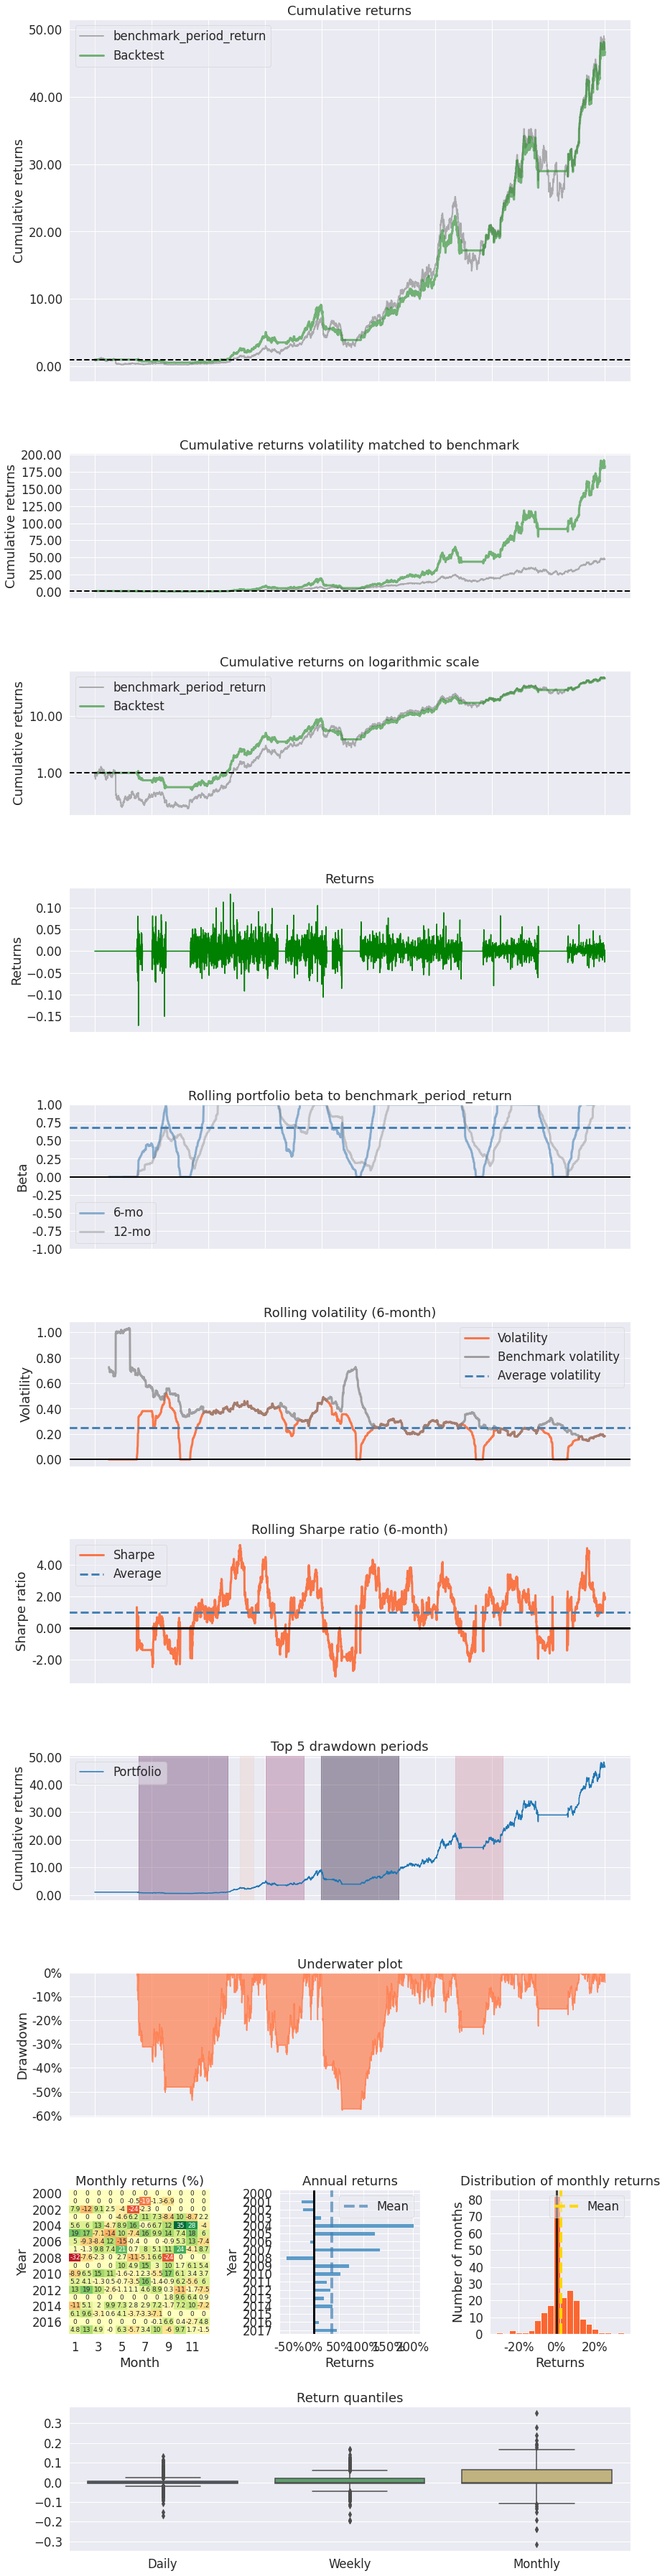

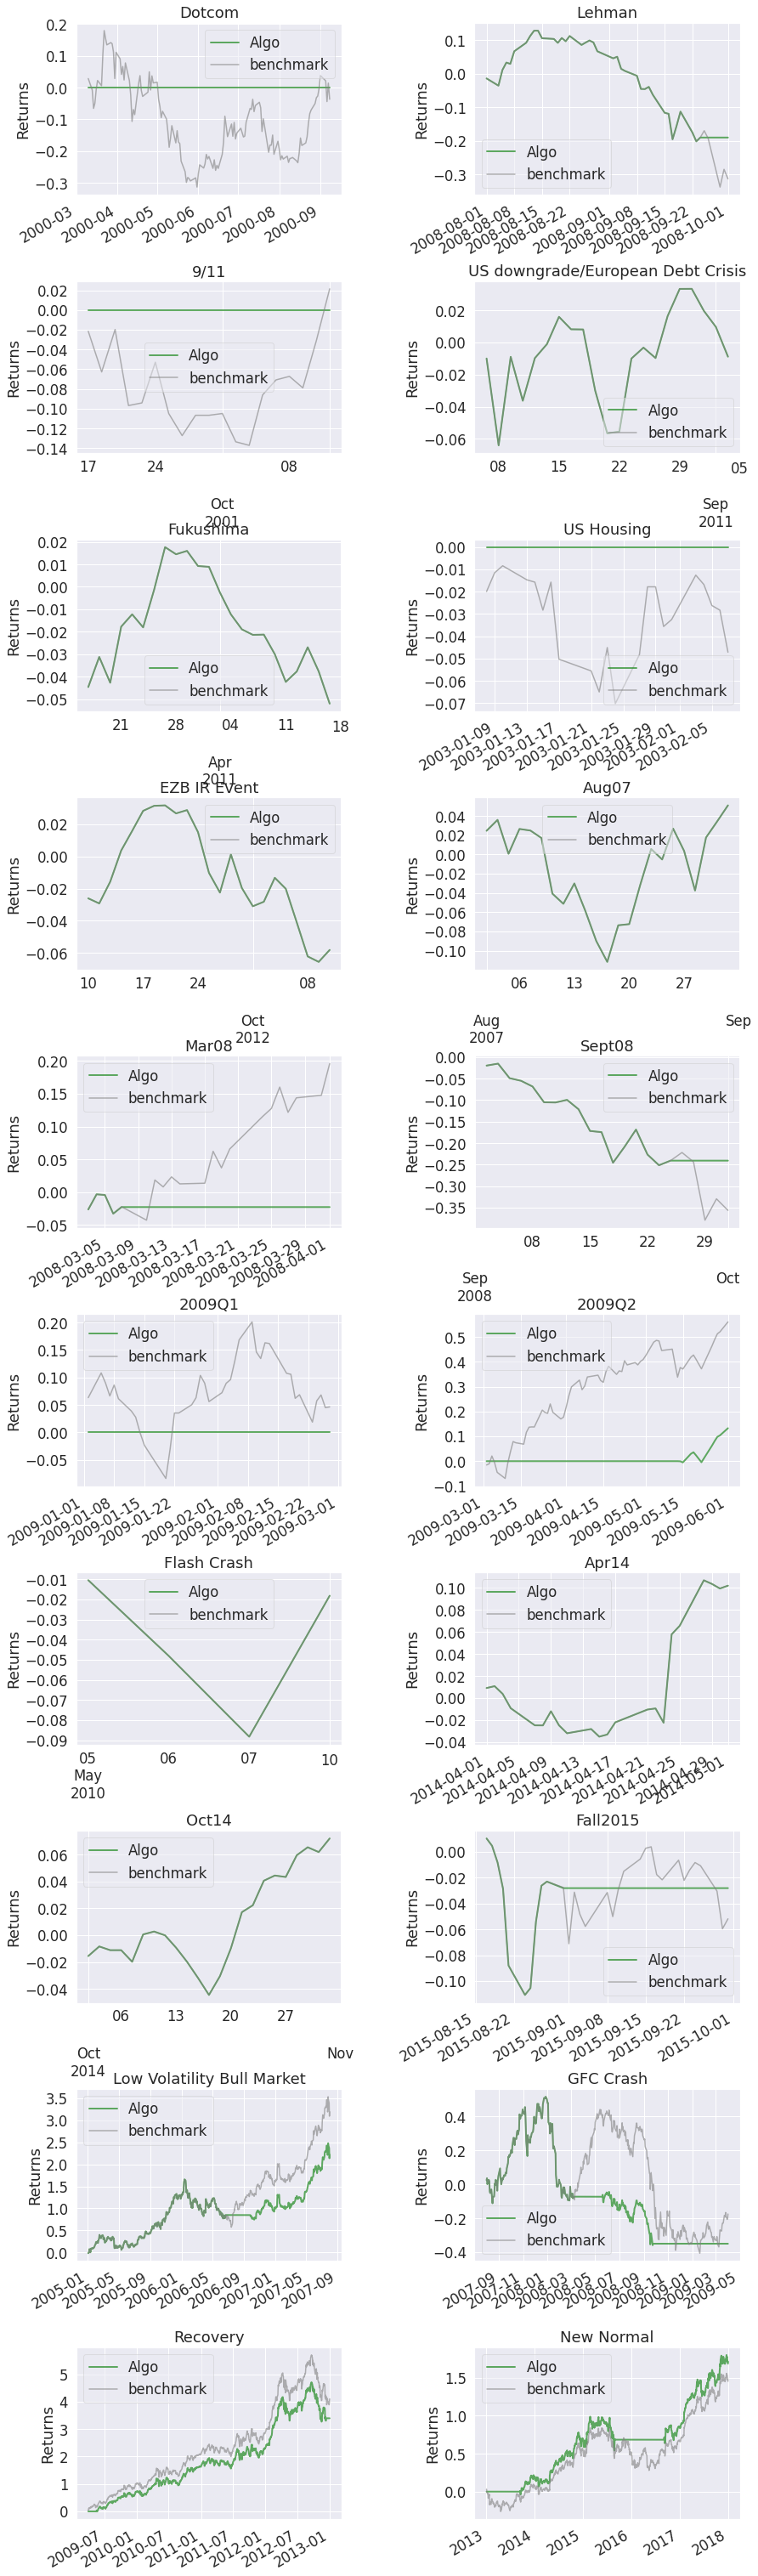

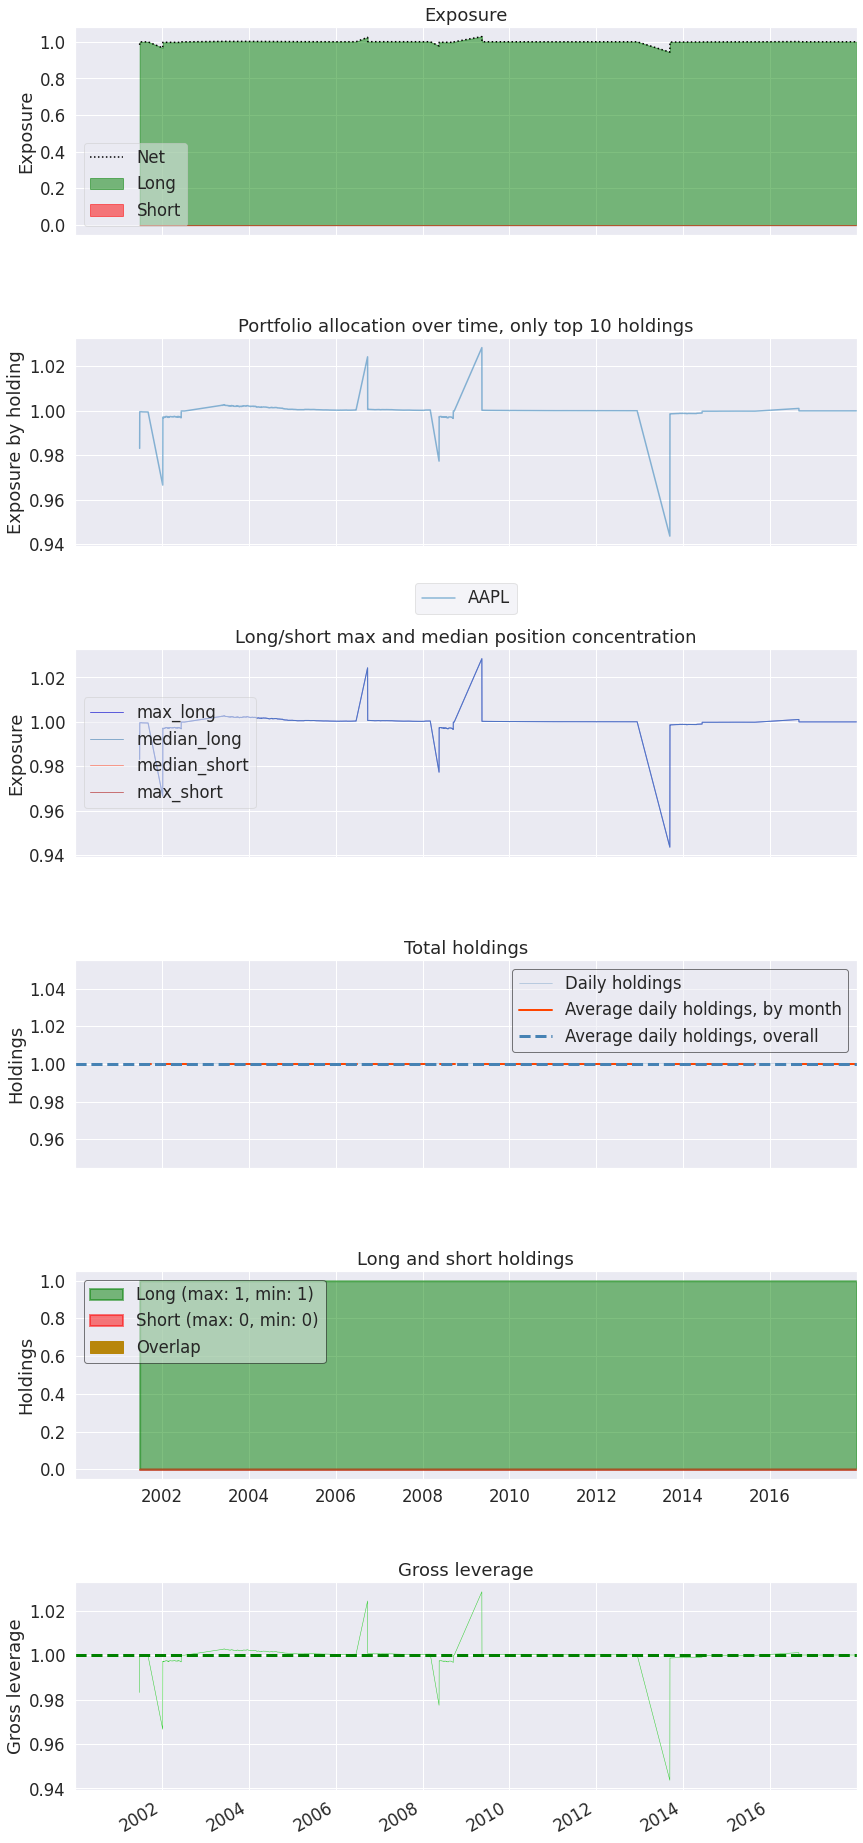

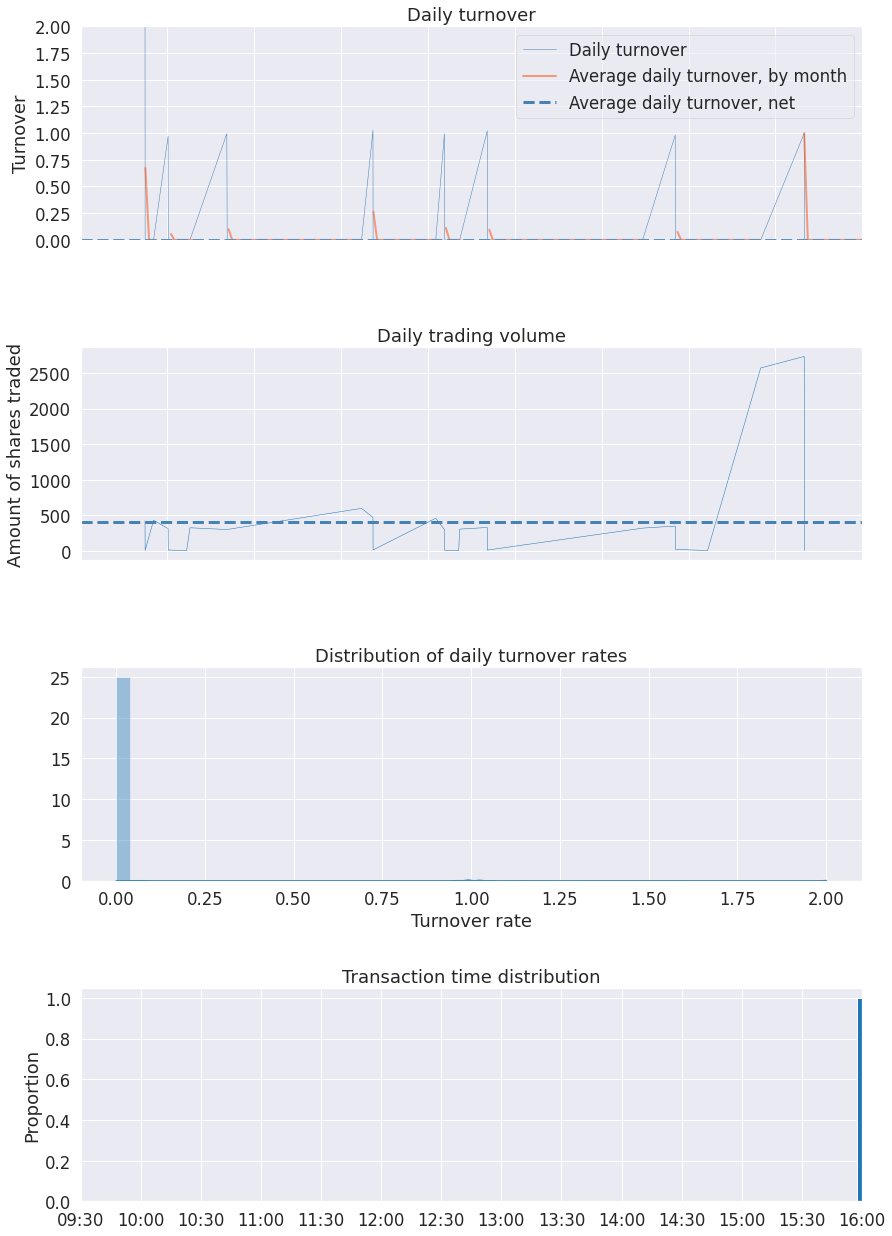

In [9]:
import pyfolio as pf
import numpy as np

# Extract algo returns and benchmark returns
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
benchmark_period_return = perf['benchmark_period_return']

# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

# Create tear sheet
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)